# 📌 Introdução

Neste arquivo vamos:

1- Importar a base de dados que raspamos;

2- Breve análise exploratória dos dados;

3- Ajustar um modelo que prevê o preço final do imóvel baseado nas variáveis disponíveis.

## 📥 Objetivo

Este documento realiza a **análise e modelagem** dos dados de imóveis utilizados na análise de preços.

## 💻 Código

Instalando e Carregando os Pacotes necessários


In [15]:
## INSTALANDO E CARREGANDO OS PACOTES NECESSÁRIOS

if (!require(tidyverse)) install.packages('tidyverse')
if (!require(ggplot2)) install.packages('ggplot2')
if (!require(ggthemes)) install.packages('ggthemes')
if (!require(viridis)) install.packages('viridis')
if (!require(caret)) install.packages('caret')
if (!require(usethis)) install.packages('usethis')


library(tidyverse)
library(ggplot2)
library(ggthemes)
library(viridis)
library(caret)
library(usethis)


In [16]:
## IMPORTANDO O DADO E FAZENDO O TRATAMENTO FINAL

dados <- read.csv2('data/dados_raspados.csv', fileEncoding = 'ISO-8859-1')
dados$X <- c()
dados$vagas_garagem[is.na(dados$vagas_garagem)] <- 0
dados <- dados |> 
  filter(cidade != 'Guarapari' & cidade != 'Linhares' & cidade != 'Santa Teresa') 

head(dados,5)


,preco,cidade,quartos,banheiros,vagas_garagem,metros_quadrados
,<dbl>,<chr>,<int>,<int>,<dbl>,<int>
1,220000,Serra,2,1,1,60
2,184000,Serra,2,1,1,45
3,870000,Serra,3,3,2,175
4,635000,Serra,3,3,3,100
5,340000,Serra,2,1,0,84


## Análise Exploratória



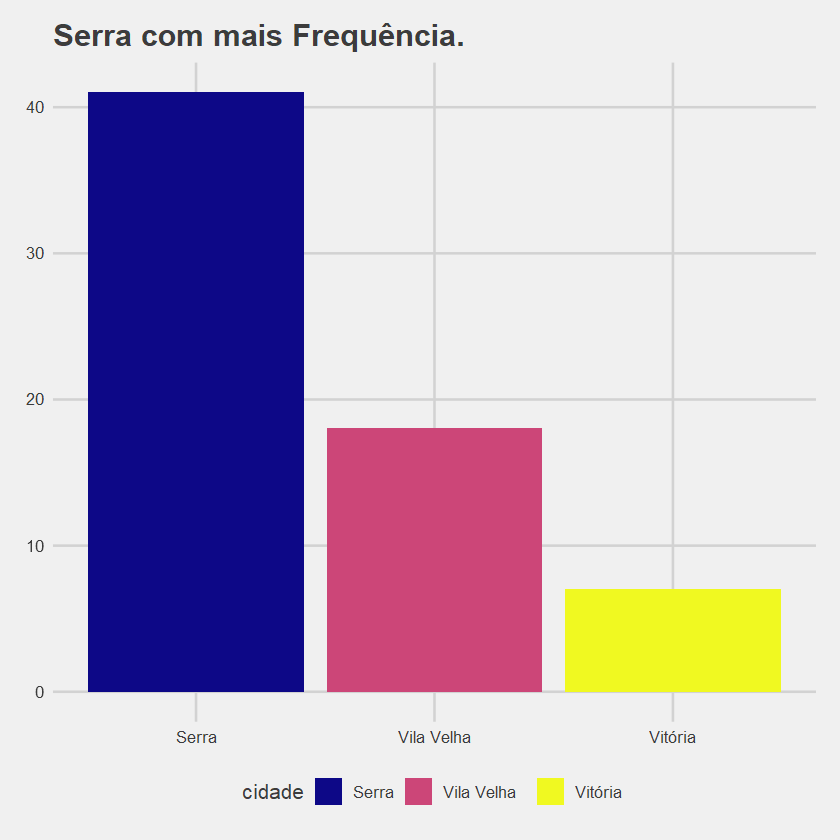

In [17]:
## ANALISANDO AS CIDADES QUE CONSTAM NA BASE DE DADOS

dados |> 
  ggplot(aes(x = fct_infreq(cidade), fill = cidade)) +
  geom_bar() +
  scale_fill_viridis_d(option = 'C') +
  theme_fivethirtyeight() +
  ggtitle('Serra com mais Frequência.') +
  xlab('Cidades')


Talvez isso dê pois de acordo com o Ministério da Economia, que divulgou o Índice de Concorrência dos Municípios (ICM) referente ao ano de 2022, a Serra consta com a melhor avaliação do Espírito Santo.



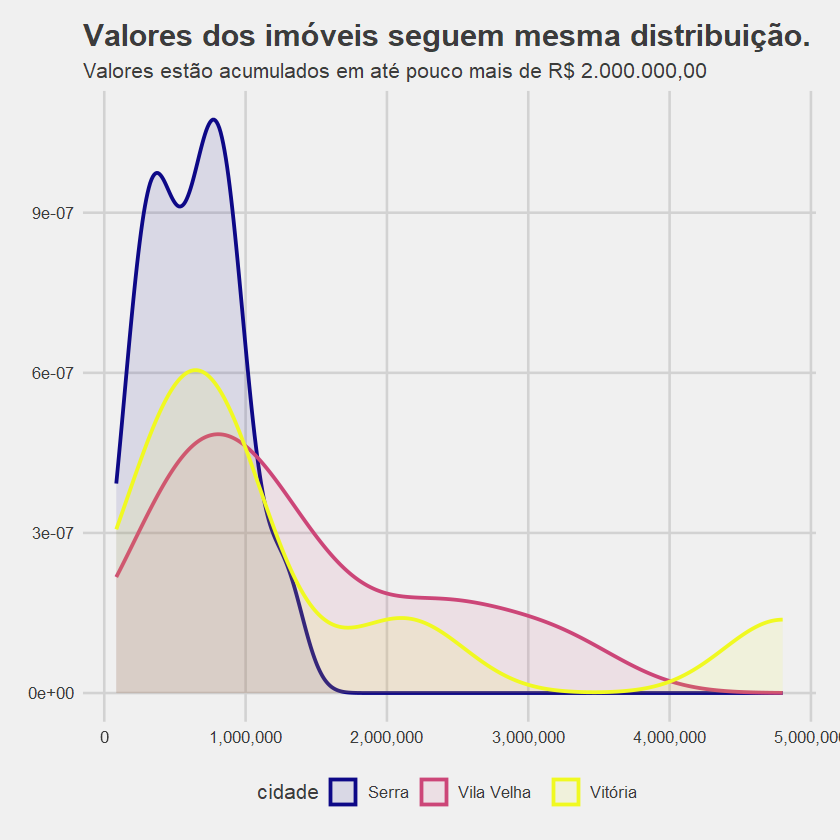

In [18]:
## VAMOS ANALISAR O VALOR DO IMÓVEL POR CIDADE

dados |> 
  ggplot(aes(x = preco, fill = cidade, color = cidade)) +
  geom_density(alpha = .1, linewidth = .8) +
  scale_fill_viridis_d(option = 'C') +
  scale_color_viridis_d(option = 'C') +
  theme_fivethirtyeight() +
  scale_x_continuous(labels = scales::comma) +
  labs(
    title = 'Valores dos imóveis seguem mesma distribuição.',
    subtitle = 'Valores estão acumulados em até pouco mais de R$ 2.000.000,00',
  )


A cidade de Vitória apresenta uma distribuição de preços bimodal, com picos de densidade em torno de R\$ 500 mil e acima de R\$ 2 milhões, sugerindo a coexistência de segmentos imobiliários distintos. Isso pode indicar a presença de desigualdade social dentro do município, refletida na diversidade de valores de imóveis. Por outro lado, cidades como Serra exibem uma distribuição mais uniforme, com preços mais concentrados em uma faixa intermediária, o que sugere maior homogeneidade no mercado imobiliário local. Assim como a cidade de Vila Velha é de certa forma mais uniforme porém com valores mais altos, indicando mais concentração de imóveis de luxo.



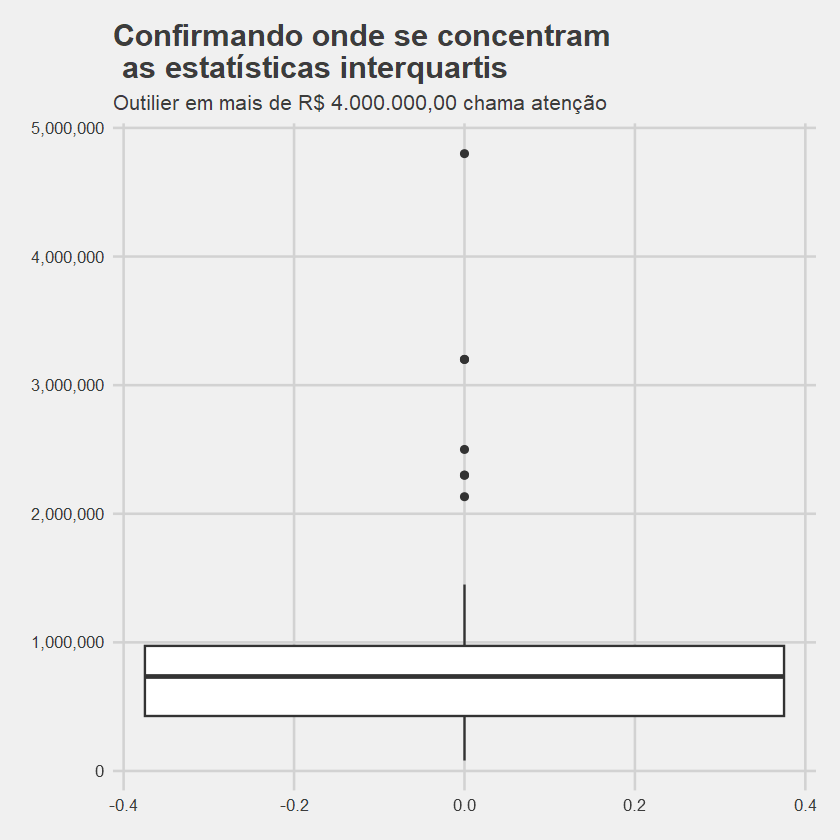

In [19]:
## ANALISANDO A DISTRIBUIÇÃO DOS PREÇOS DOS IMÓVEIS

dados |> 
  ggplot(aes(y = preco)) + 
  geom_boxplot() +
  scale_y_continuous(labels = scales::comma) +
  labs(
    title = 'Confirmando onde se concentram\n as estatísticas interquartis',
    subtitle = 'Outilier em mais de R$ 4.000.000,00 chama atenção'
  ) +
  theme_fivethirtyeight()


Como visto, os valores se concentram em R\$ 1.000.000,00 para baixo, com alguns outliers, um deles, chama atenção por passar de R\$ 4.000.000,00.

Para melhor entendimento, vamos dar um *zoom* no gráfico de densidade


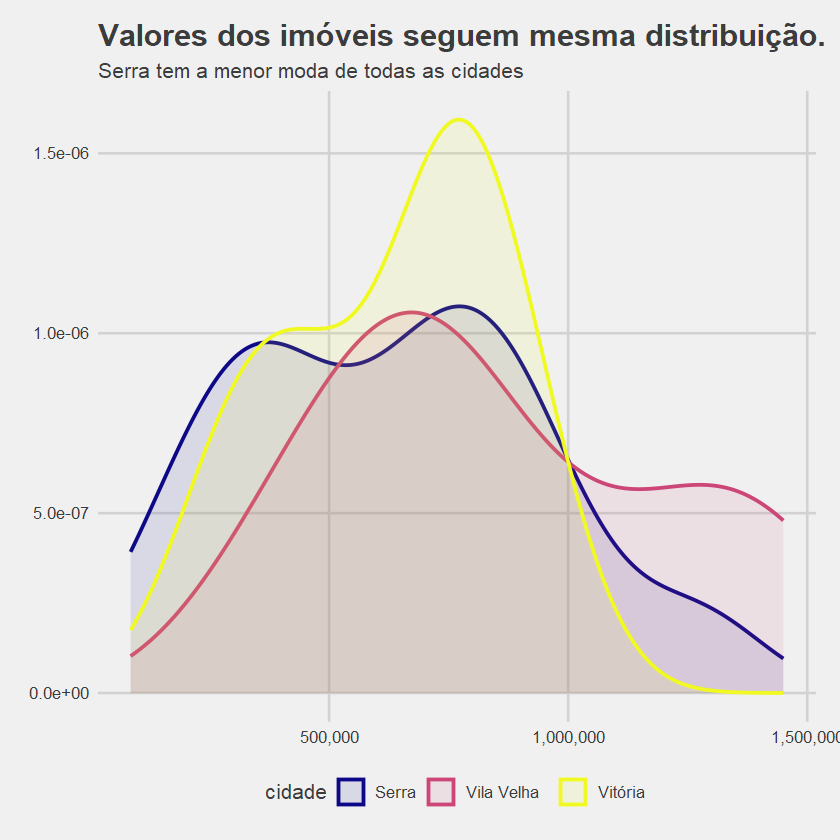

In [20]:
dados |> 
  filter(preco <= 2000000) |> 
  ggplot(aes(x = preco, fill = cidade, color = cidade)) +
  geom_density(alpha = .1, linewidth = .8) +
  scale_fill_viridis_d(option = 'C') +
  scale_color_viridis_d(option = 'C') +
  theme_fivethirtyeight() +
  scale_x_continuous(labels = scales::comma) +
  labs(
    title = 'Valores dos imóveis seguem mesma distribuição.',
    subtitle = 'Serra tem a menor moda de todas as cidades'
  )
  


A distribuição de Vitória se parece muito com a de Serra, só que um pouco para direita, indicando que sua moda é maior, assim como Vila Velha é maior que Vitória, porém Vitória tem picos de densidade acumulada em valores mais altos.



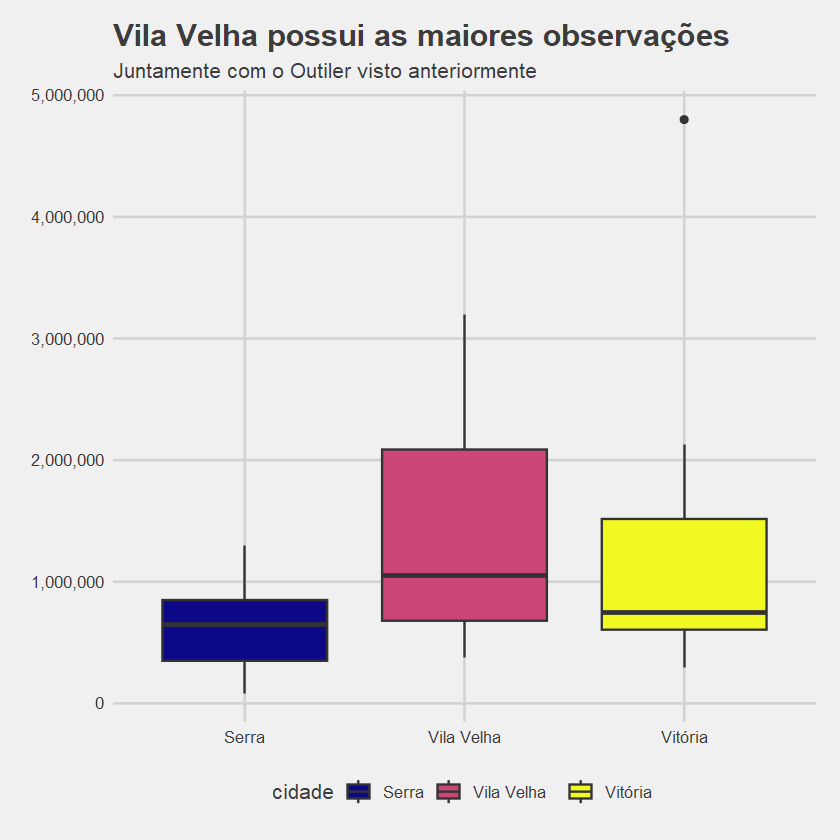

In [21]:
## VAMOS ANALISAR A DISTRIBUIÇÃO DOS PRECOS POR CIDADE

dados |> 
  ggplot(aes(x= cidade, y = preco, fill = cidade)) +
  geom_boxplot() +
  scale_y_continuous(labels = scales::comma) +
  theme_fivethirtyeight() +
  scale_fill_viridis_d(option = 'C') +
  labs(
    title = 'Vila Velha possui as maiores observações',
    subtitle = 'Juntamente com o Outiler visto anteriormente'
  )


O boxplot mostra que Vila Velha possui os imóveis com maior valor. Vitória, embora com valores altos, tem uma distribuição mais dispersa, e a cidade da Serra aparece como intermediária, com presença de imóveis de menor padrão.

## Analisando a relação entre as variáveis


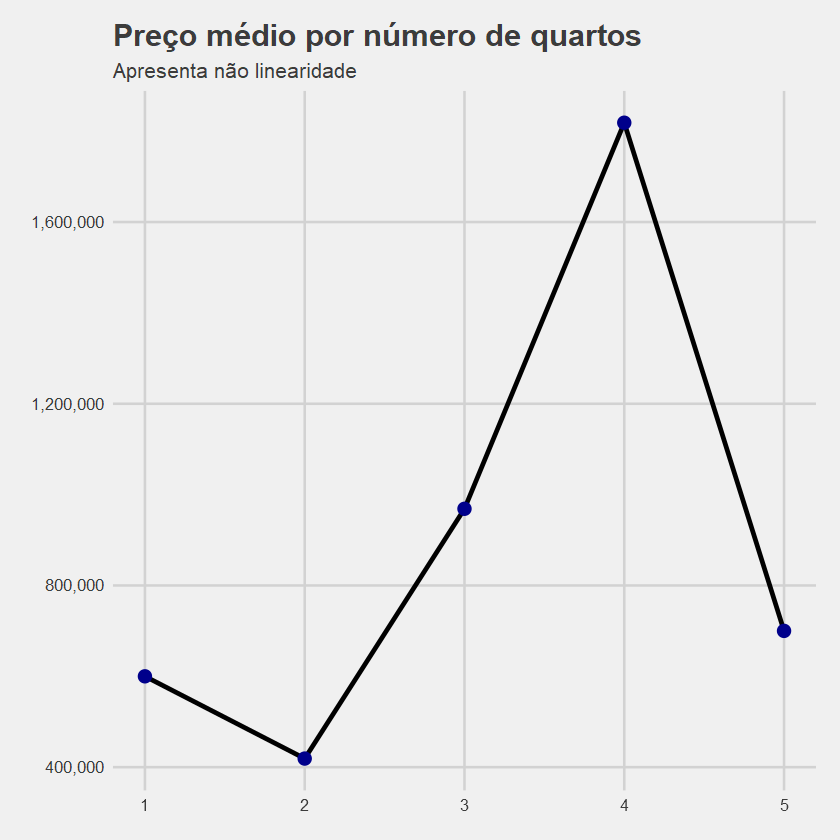

In [22]:
## VAMOS VER A RELAÇÃO DE QUARTO POR PREÇO

dados |> 
  group_by(quartos) |> 
  summarise(media_preco = mean(preco, na.rm = T)) |> 
  ggplot(aes(x = quartos, y = media_preco)) +
  geom_line(linewidth = 1) +
  geom_point(size = 3, color = 'darkblue') +
  scale_y_continuous(labels = scales::comma) +
  labs(
    x = "Número de quartos",
    y = "Preço médio do imóvel",
    title = "Preço médio por número de quartos",
    subtitle = 'Apresenta não linearidade'
  ) +
  theme_fivethirtyeight()


Os dados apresentam uma leve contra intuitividade, com quatro quartos tendo a maior média de valor de imóvel.



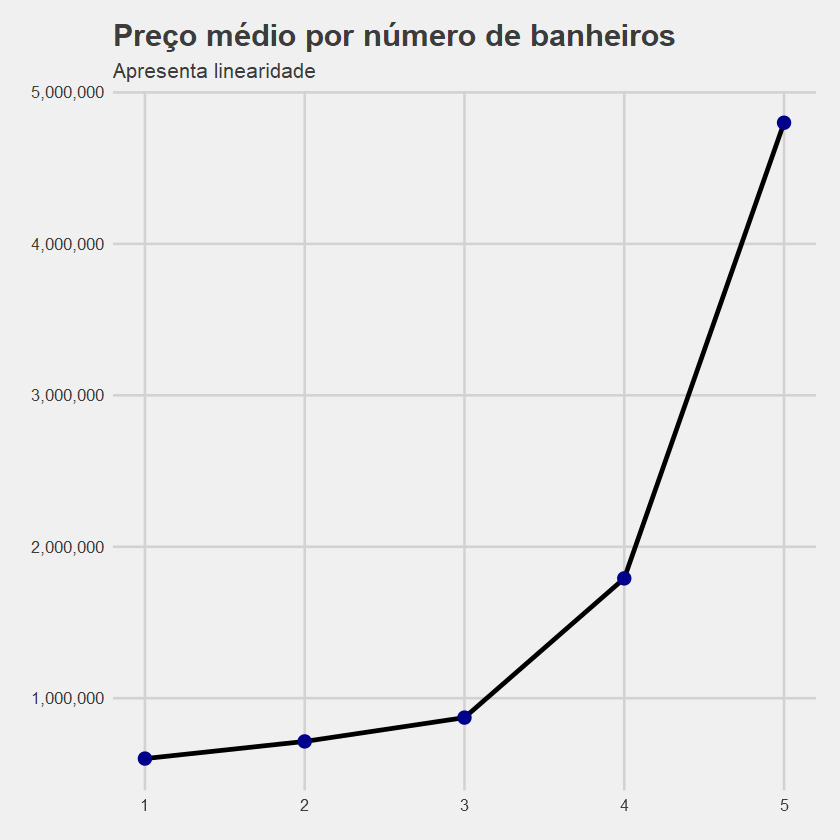

In [23]:
## OBSERVANDO A RELAÇÃO DE BANHEIROS POR PREÇO

dados |> 
  group_by(banheiros) |> 
  summarise(media_preco = mean(preco, na.rm = T)) |> 
  ggplot(aes(x = banheiros, y = media_preco)) +
  geom_line(linewidth = 1) +
  geom_point(size = 3, color = 'darkblue') +
  scale_y_continuous(labels = scales::comma) +
  labs(
    x = "Número de banheiros",
    y = "Preço médio do imóvel",
    title = "Preço médio por número de banheiros",
    subtitle = 'Apresenta linearidade'
  ) +
  theme_fivethirtyeight()


Os imóveis seguem a linha de raciocínio comum em que quanto mais banheiro um imóvel tem, maior o seu valor.



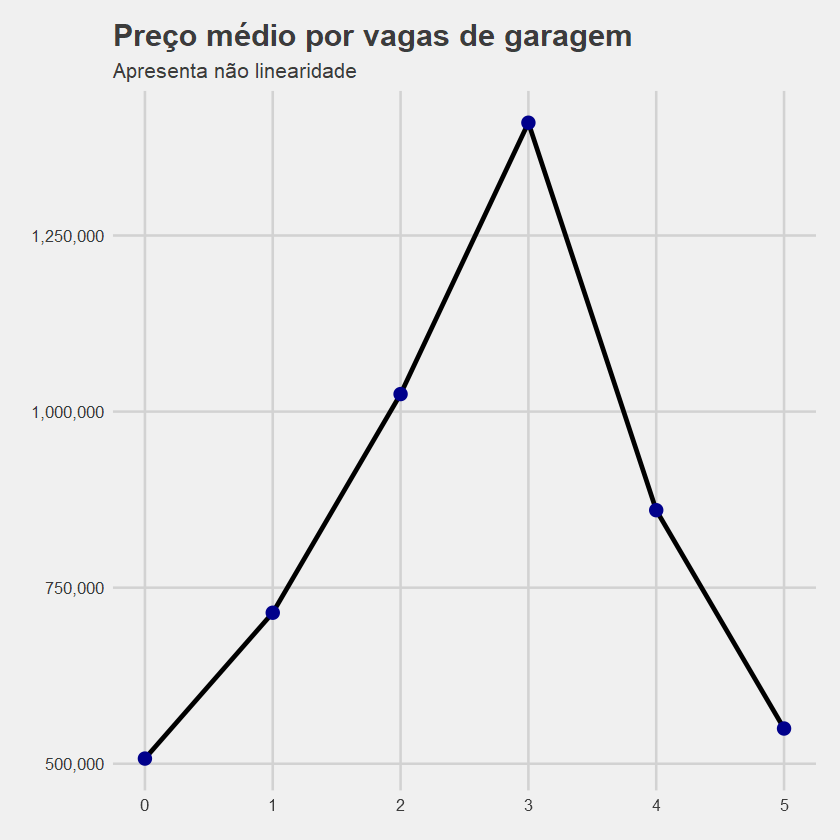

In [24]:
## OBSERVANDO A RELAÇÃO DE GARAGEM POR PREÇO

dados |> 
  group_by(vagas_garagem) |> 
  summarise(media_preco = mean(preco, na.rm = T)) |> 
  ggplot(aes(x = vagas_garagem, y = media_preco)) +
  geom_line(linewidth = 1) +
  geom_point(size = 3, color = 'darkblue') +
  scale_y_continuous(labels = scales::comma) +
  labs(
    x = "Número de vagas de garagem",
    y = "Preço médio do imóvel",
    title = "Preço médio por vagas de garagem",
    subtitle = 'Apresenta não linearidade'
  ) +
  theme_fivethirtyeight()


Os imóveis com a maior média de preço possuem até três vagas.



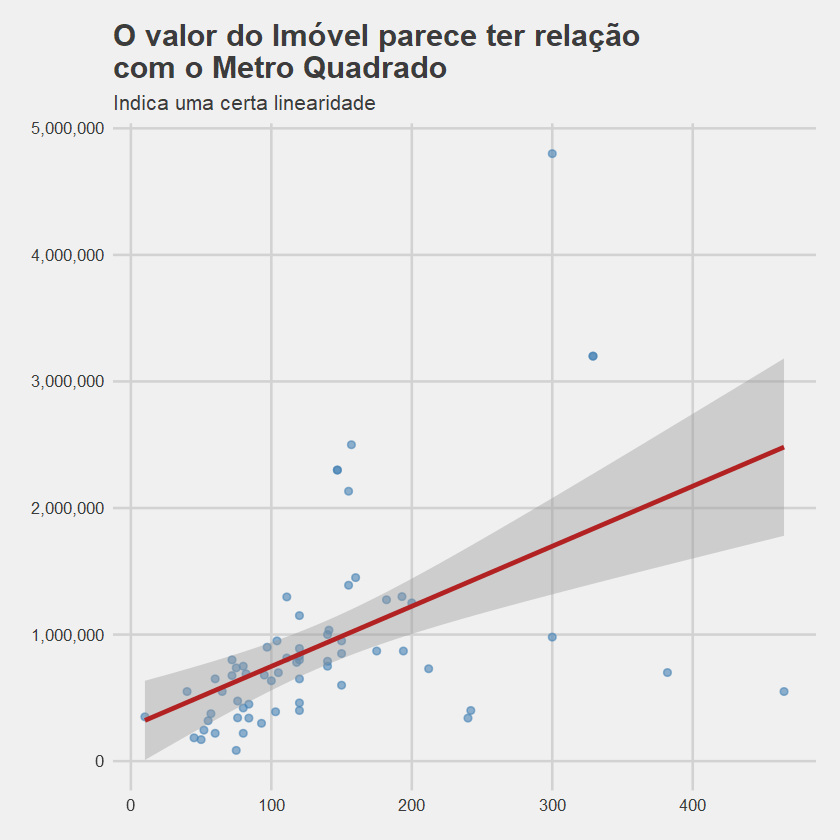

In [25]:
## OBSERVANDO A RELAÇÃO DE METRO QUADRADO POR PREÇO

dados |>
  ggplot(aes(x = metros_quadrados, y = preco)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_smooth(method = "lm", formula = y ~ x, color = "firebrick", se = TRUE) +
  scale_y_continuous(labels = scales:::comma) +
  labs(
    title = 'O valor do Imóvel parece ter relação\ncom o Metro Quadrado',
    subtitle = 'Indica uma certa linearidade'
  ) +
  theme_fivethirtyeight()


Para termos mais assertividade vamos transformar os dados e então montarmos o gráfico novamente.



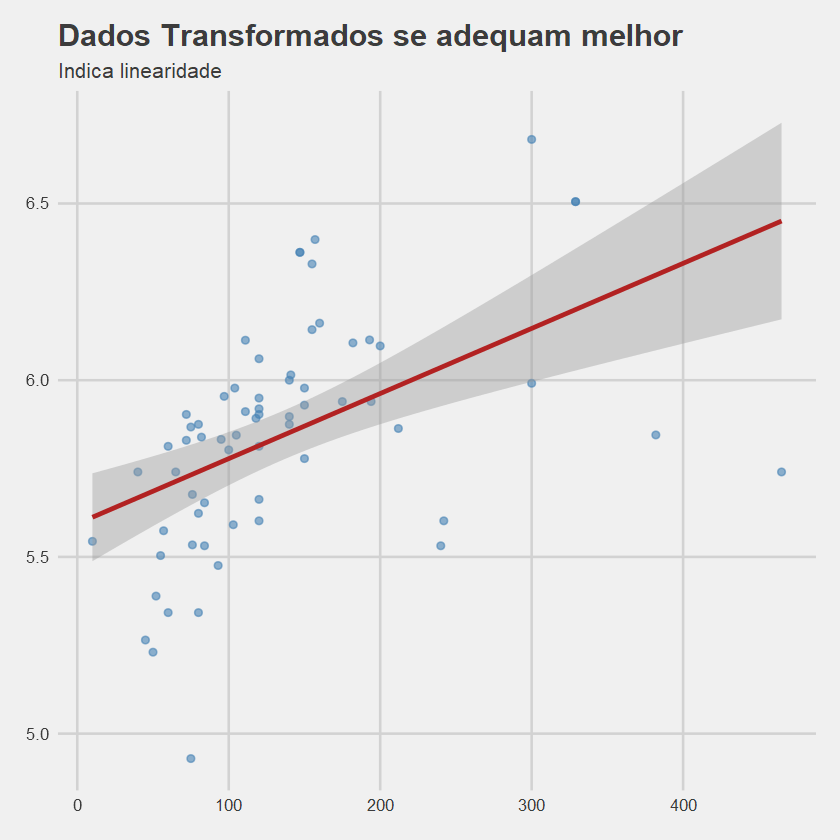

In [26]:
dados$log_preco <- log10(dados$preco)

dados |>
  filter(metros_quadrados < 500) |> 
  ggplot(aes(x = metros_quadrados, y = log_preco)) +
  geom_point(alpha = 0.6, color = "steelblue") +
  geom_smooth(method = "lm", formula = y ~ x, color = "firebrick", se = TRUE) +
  labs(
    title = 'Dados Transformados se adequam melhor',
    subtitle = 'Indica linearidade'
  ) +
  theme_fivethirtyeight()
  


Os dados se adequaram bem melhor e indica uma boa relação de linearidade entre as variáveis.

Vamos tentar ajustar um modelo

# Modelo básico


In [27]:
modelo <- lm(
  log_preco ~ log(metros_quadrados) + banheiros + cidade + quartos,
  data = dados)

summary(modelo)



Call:
lm(formula = log_preco ~ log(metros_quadrados) + banheiros + 
    cidade + quartos, data = dados)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56263 -0.11814  0.00454  0.12051  0.32134 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.59445    0.19733  23.283  < 2e-16 ***
log(metros_quadrados)  0.13549    0.05436   2.492  0.01547 *  
banheiros              0.07497    0.03012   2.489  0.01561 *  
cidadeVila Velha       0.28700    0.05462   5.255 2.07e-06 ***
cidadeVitória          0.26132    0.08013   3.261  0.00183 ** 
quartos                0.11882    0.04734   2.510  0.01479 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1911 on 60 degrees of freedom
Multiple R-squared:  0.6721,	Adjusted R-squared:  0.6448 
F-statistic:  24.6 on 5 and 60 DF,  p-value: 2.193e-13


O modelo se encaixa suficientemente bem, com todas variáveis estatisticamente significativas, uma amplitude de resíduos baixas e $R^2$ de 64,5%.

Vamos salvar o modelo e os dados e passar para a fase de testes.


In [28]:
saveRDS(modelo, 'modelo/modelo.rds')
saveRDS(dados, 'data/dados.rds')
